Example notebook to have a look at the results of 'vasca_pipe -cfg ../vasca_cfg.yaml' from the examples folder.
The output of the pipline was stored in the folder vasca_pipeline.# General seup and library loading

General path seup and library loading

In [10]:
%matplotlib widget
import matplotlib.pyplot as plt
from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis

from jdaviz import Imviz
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import fits

region_fname = "./vasca_pipeline/TDS_COSMOS/region_TDS_COSMOS.fits"

Show basic region information

In [11]:
rg = Region()
rg.load_from_fits(region_fname)
rg.tt_fields.show_in_notebook()
#rg.info() # Show available tablea

idx,field_id,name,ra,dec,observatory,obs_filter,sel,fov_diam,nr_vis,time_bin_size_sum,time_start,time_stop
,,,deg,deg,,,,deg,,s,d,d
0,2604912508670050304,PS_COSMOS_MOS21,150.50213748204703,3.09702777491166,GALEX,NUV,True,1.1,29,28075.799999999996,54510.593935185185,56535.16921296297
1,2604982877414227968,PS_COSMOS_MOS22,149.49989874061703,3.10005767451708,GALEX,NUV,True,1.1,29,27164.39999999999,54509.566979166666,56515.80884259259


Show visits informtation

Plot light curves for some selected sources and show first points of lightcurve in BinnedTimeSeries format

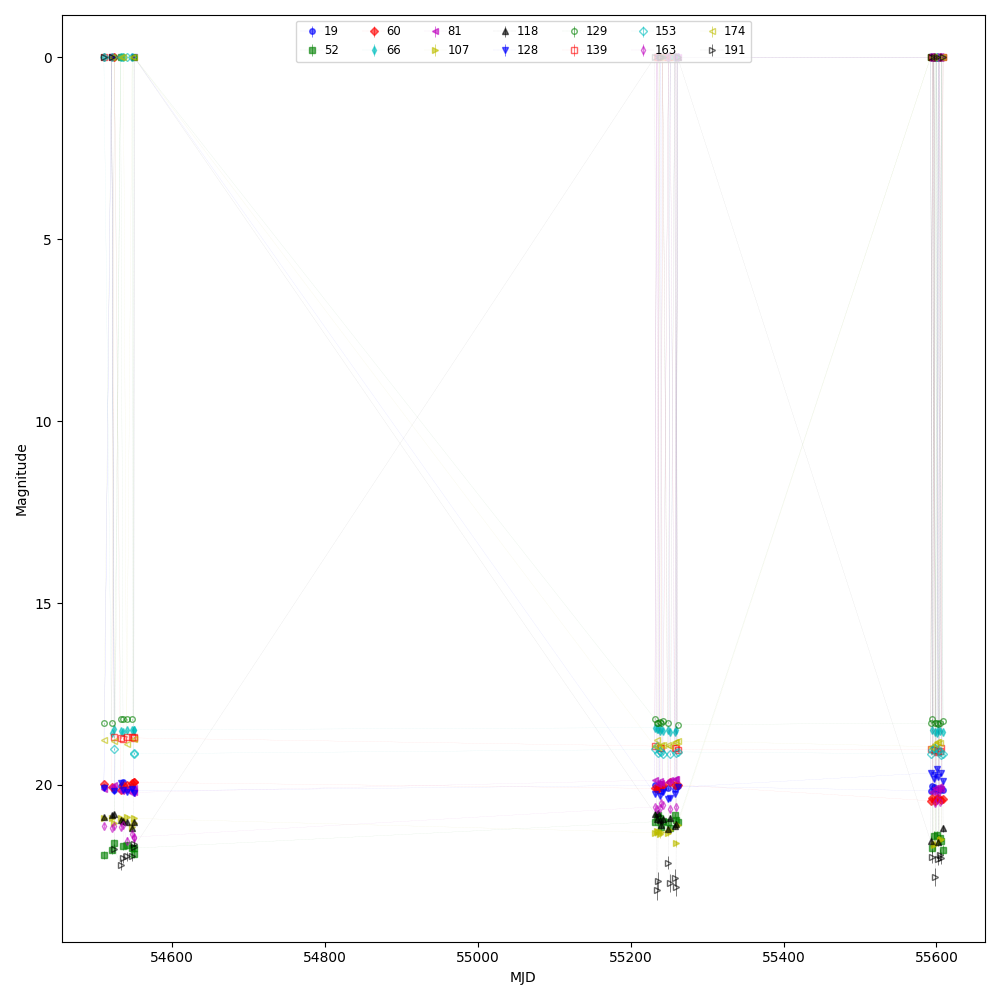

idx,time_start,time_delta,mag,mag_err,ul,sel
,d,s,,,,
0,54510.59375,1275.6500244140625,20.05954933166504,0.037015367299318314,18.353994369506836,True
1,54520.66015625,1166.6500244140625,0.0,0.0,18.130695343017578,True
2,54524.42578125,1065.5999755859375,20.125635147094727,0.037001851946115494,17.904199600219727,True
3,54532.5078125,1221.5999755859375,20.04068946838379,0.03399533033370972,18.245758056640625,True


In [12]:
sel = rg.tt_sources["sel"]
rg_src_ids = rg.tt_sources[sel]["rg_src_id"][0:14]
fig_lc = plt.figure(figsize=(10, 10))
vvis.plot_light_curve(rg,rg_src_ids=rg_src_ids)
plt.tight_layout()
plt.show()
lcs = rg.get_light_curve(rg_src_ids=rg_src_ids)
lcs[rg_src_ids[0]][0:4].show_in_notebook()

Display the lightcurve info for some more selected sources

Look at sky of specific field

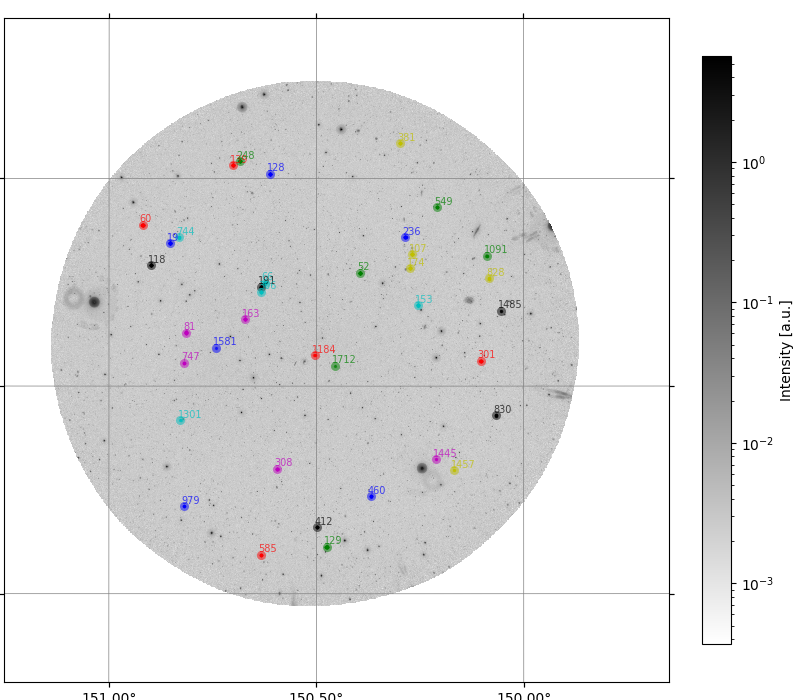

In [13]:
field_id = 2604912508670050304
fd = rg.fields[field_id]
fig_sky = vvis.plot_field_sky(fd,plot_detections=True)

Get coverage hp map and plot in sky

<HpxGnomonicAxes: title={'center': 'Nr. of visits'}>

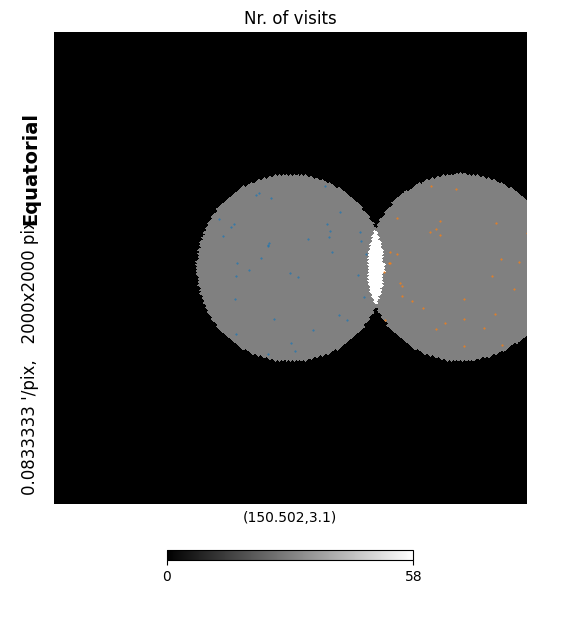

In [14]:
rg.add_coverage_hp(nside=4096)
vvis.plot_region_sky_gnomeview(rg,rg.tt_fields[0]["ra"],rg.tt_fields[1]["dec"])
#write healpix map to Aladin format, modify names
# hpy.fitsfunc.write_map(filename,[hp_vis, hp_exp],coord="C",column_names=["nr_vis", "exposure"],dtype=[np.float32, np.float32],overwrite=True,partial=True)

Plot sky image with Imviz, show source and detection markers on-top

In [15]:
hdup = fits.PrimaryHDU(fd.ref_img, header=fd.ref_wcs.to_header())
imviz = Imviz()
viewer = imviz.default_viewer
imviz.load_data(hdup, data_label=str(field_id))
imviz.show(loc='sidecar')

sel_det = fd.tt_detections["sel"]
tt_det_sky = Table({'coord': SkyCoord(fd.tt_detections[sel_det]["ra"], fd.tt_detections[sel_det]["dec"], frame='fk5')})
viewer.marker = {'color':'blue', 'markersize': 5., 'fill': False} #, 'alpha': 1.0
viewer.add_markers(tt_det_sky, use_skycoord=True, marker_name='D')

srcs_sky = SkyCoord(fd.tt_sources["ra"], fd.tt_sources["dec"], frame='fk5')
tt_srcs_sky = Table({'coord':srcs_sky })
viewer.marker = {'color':'red', 'markersize': 2., 'fill': True} #, 'alpha': 1.0
viewer.add_markers(tt_srcs_sky, use_skycoord=True, marker_name='S')

Show field diagnostic plots

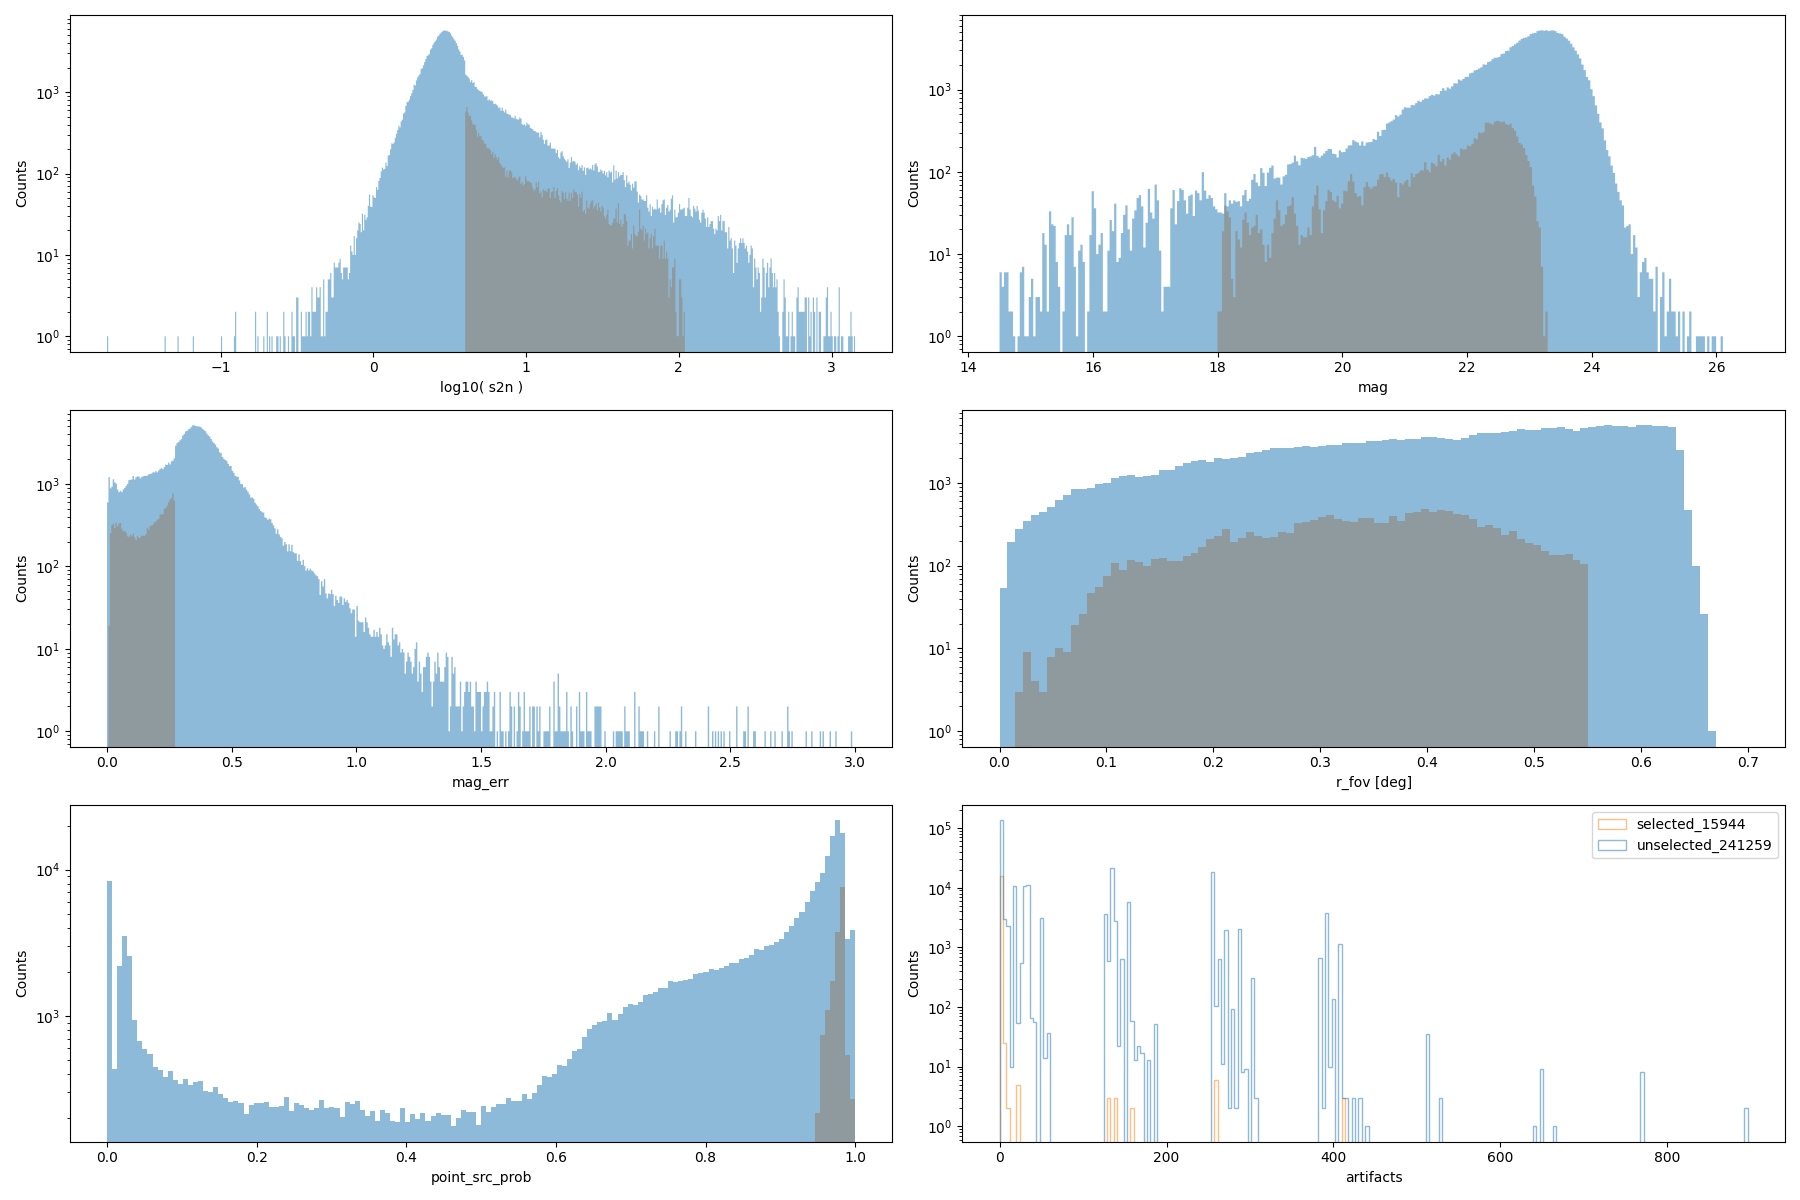

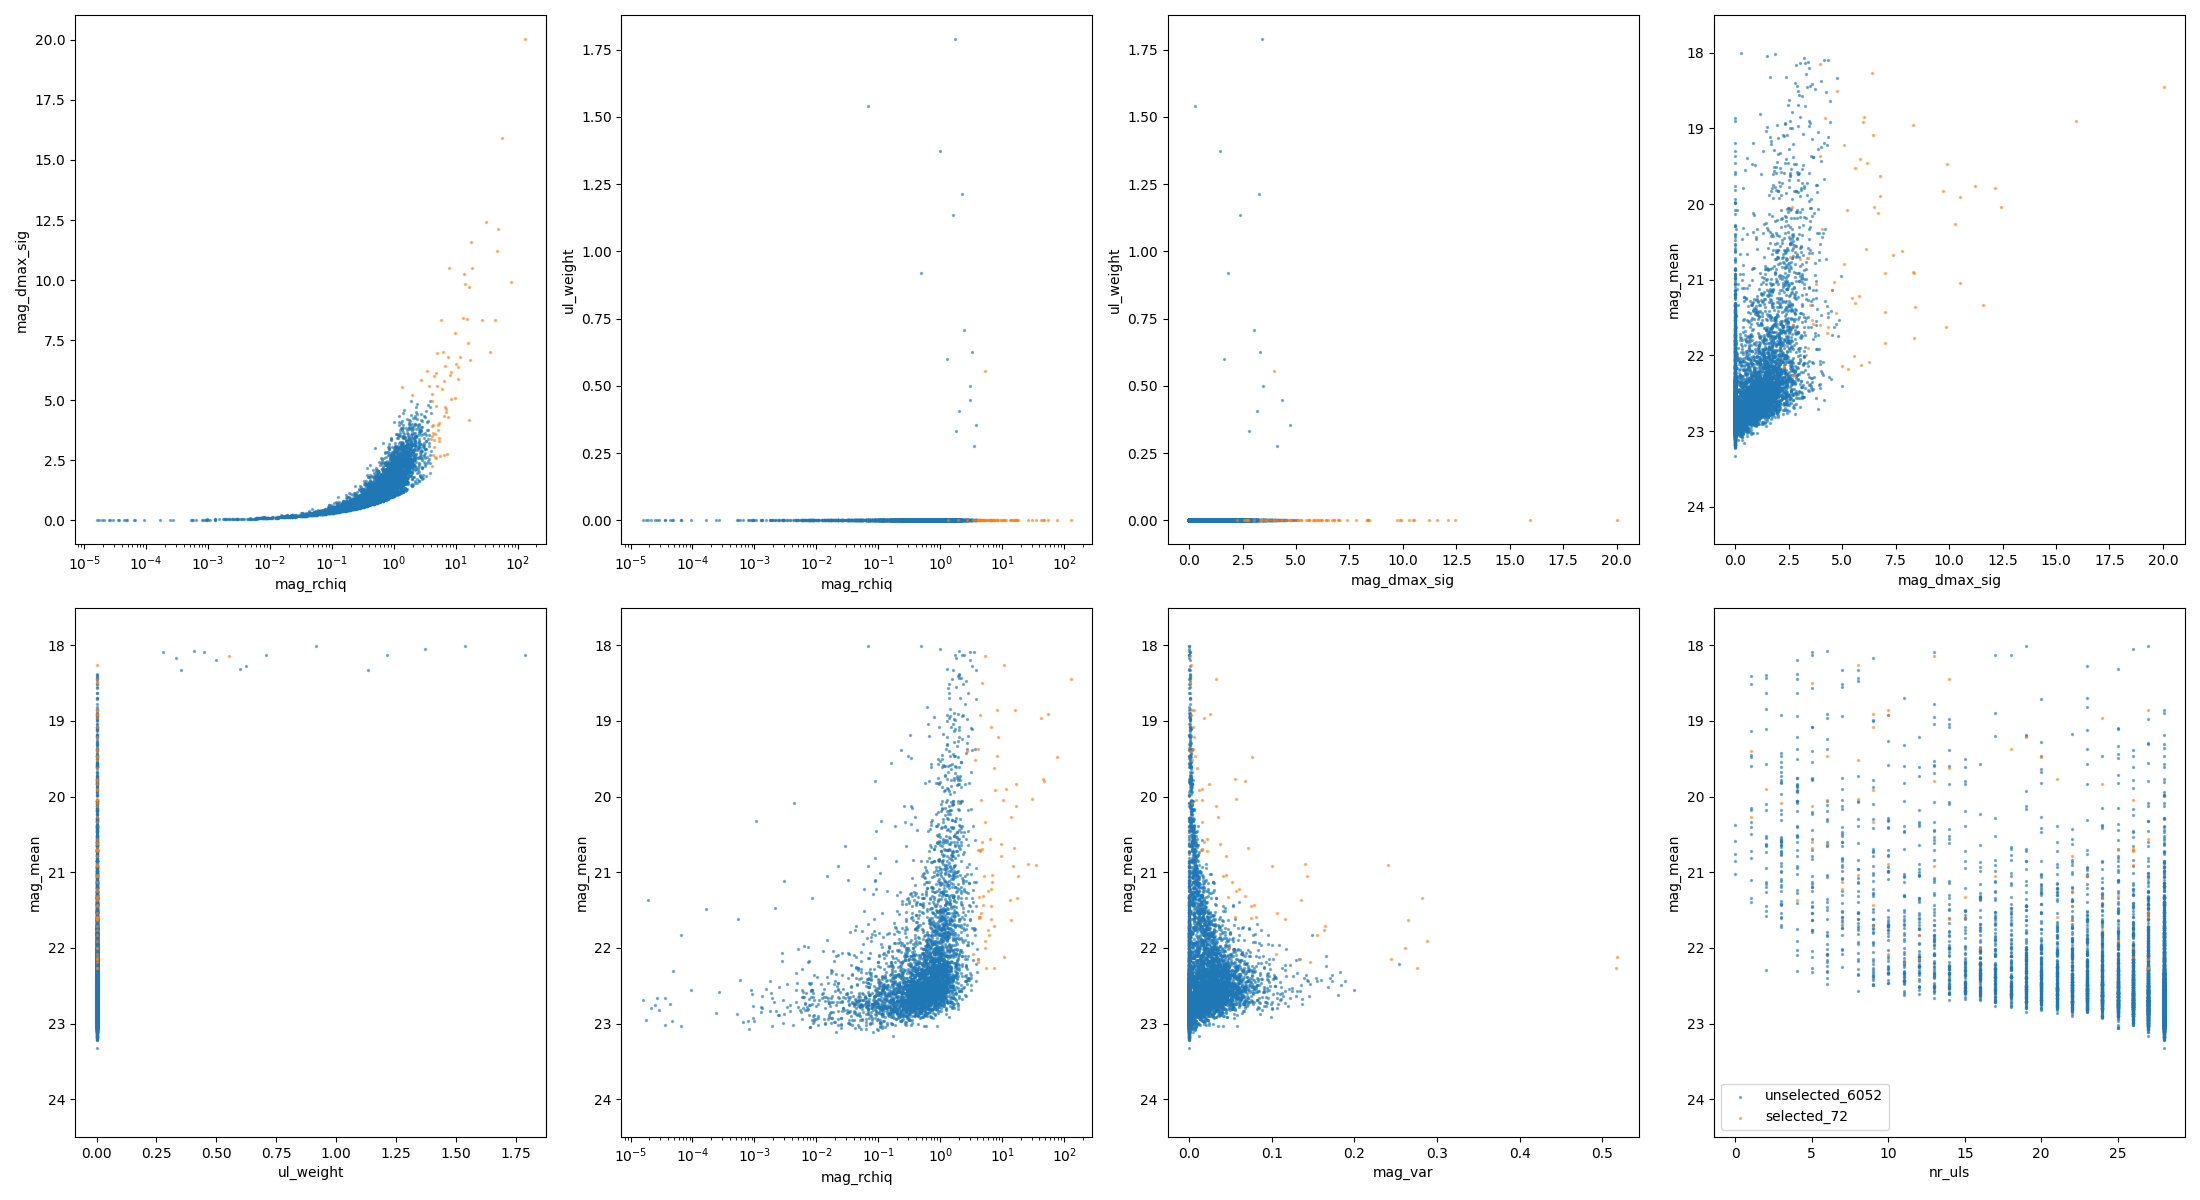

In [16]:
fig_fd_det_diag_hist = vvis.plot_pipe_diagnostic(fd, "tt_detections", "hist")
fig_rg_src_diag_scat = vvis.plot_pipe_diagnostic(rg, "tt_sources", "scatter")